In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import Locator, MaxNLocator # added 
from tqdm import tqdm
from scipy import stats, interpolate
import yaml

from n3jet.general import SingleModelRun, FKSModelRun


Bad key "legend.title_fontsize" on line 22 in
/mt/home/jbullock/.config/matplotlib/stylelib/notebook.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution
Using TensorFlow backend.


## Set up

In [31]:
single_yaml_file = '/mt/home/jbullock/n3jet/n3jet/runs/runs/diphoton/3g2A/RAMBO/parallel_fixed/single_all_legs_all_pairs_new_sherpa_cuts_pdf_njet.yaml'

In [32]:
fks_yaml_file = '/mt/home/jbullock/n3jet/n3jet/runs/runs/diphoton/3g2A/RAMBO/parallel_fixed/fks_all_legs_all_pairs_new_sherpa_cuts_pdf_njet.yaml'

In [33]:
save_dir = 'paper_plots/5_point/error_plots/'

In [34]:
save_fig = 'unit_error_plot_joint'

In [35]:
grid_type = 'unit' # vegas or unit
legs = 5

## Data processing

### Single model

In [36]:
test_single_model = SingleModelRun.from_yaml(single_yaml_file, training=False)

/mt/home/jbullock/n3jet/n3jet/runs/runs/diphoton/3g2A/RAMBO/parallel_fixed/single_all_legs_all_pairs_new_sherpa_cuts_pdf_njet.yaml


In [37]:
test_single_momenta, test_single_nj = test_single_model.load_data()

############### Momenta loaded ###############
############### NJet loaded ###############
Training on 1000000 PS points


In [38]:
test_single_momenta, test_single_nj = test_single_model.recut_data(test_single_momenta, test_single_nj)

100%|██████████| 1000000/1000000 [00:38<00:00, 25701.56it/s]


In [39]:
assert len(test_single_momenta) == len(test_single_nj)

In [40]:
test_points = len(test_single_momenta)

In [41]:
model_dir_new = test_single_model.model_base_dir + test_single_model.model_dir

In [42]:
nn_all = []
nn_near_all = []
for t in tqdm(range(test_single_model.training_reruns)):
    nn = np.load(model_dir_new + '_{}/pred_{}.npy'.format(t,test_points), allow_pickle=True)
    nn_all.append(nn)

nn_std = np.std(nn_all, ddof=1, axis=0)
    
nn_mean = np.mean(nn_all, axis=0)
    
assert len(nn_mean) == len(test_single_nj)

100%|██████████| 20/20 [00:00<00:00, 122.35it/s]


In [43]:
total_single_momenta = test_single_momenta
total_single_nj = test_single_nj
total_single_nn = nn_mean

### FKS model

In [44]:
test_fks_model = FKSModelRun.from_yaml(fks_yaml_file, training=False)

/mt/home/jbullock/n3jet/n3jet/runs/runs/diphoton/3g2A/RAMBO/parallel_fixed/fks_all_legs_all_pairs_new_sherpa_cuts_pdf_njet.yaml


In [45]:
test_momenta, test_nj = test_fks_model.load_data()

############### Momenta loaded ###############
############### NJet loaded ###############
Training on 1000000 PS points


In [46]:
cut_momenta, near_momenta, cut_nj, near_nj, pairs, _, weights = test_fks_model.split_data(
    momenta = test_momenta, 
    nj = test_nj,
    return_weights = True
)

  1%|          | 907/88451 [00:00<00:09, 9069.27it/s]

Pair 1 of 9


  0%|          | 0/88451 [00:00<?, ?it/s]

Pair 2 of 9


  2%|▏         | 2139/88451 [00:00<00:04, 21285.53it/s]

Pair 3 of 9


  2%|▏         | 1339/88451 [00:00<00:06, 13389.06it/s]

Pair 4 of 9


  2%|▏         | 1947/88451 [00:00<00:04, 19467.47it/s]

Pair 5 of 9


  1%|▏         | 1286/88451 [00:00<00:06, 12854.59it/s]

Pair 6 of 9


  2%|▏         | 1790/88451 [00:00<00:04, 17891.74it/s]

Pair 7 of 9


  2%|▏         | 1962/88451 [00:00<00:04, 19617.63it/s]

Pair 8 of 9


  2%|▏         | 1780/88451 [00:00<00:04, 17797.90it/s]

Pair 9 of 9


100%|██████████| 88451/88451 [00:05<00:00, 15353.64it/s]


In [47]:
cut_nj = np.array(cut_nj)
near_nj = np.array(near_nj)
total_nj = np.concatenate((cut_nj, near_nj))
total_momenta = np.concatenate((cut_momenta, near_momenta))

In [48]:
assert len(total_nj) == len(test_momenta)
assert len(total_momenta) == len(test_momenta)

test_points = len(test_momenta)
model_dir_new = test_fks_model.model_base_dir + test_fks_model.model_dir

In [49]:
nn_cut_all = []
nn_near_all = []
for t in tqdm(range(test_fks_model.training_reruns)):
    nn_cut = np.load(model_dir_new + '_{}/pred_cut_{}.npy'.format(t,test_points), allow_pickle=True)
    nn_near = np.load(model_dir_new + '_{}/pred_near_{}.npy'.format(t,test_points), allow_pickle=True)
    nn_cut_all.append(nn_cut)
    nn_near_all.append(nn_near)

nn_cut_std = np.std(nn_cut_all, ddof=1, axis=0)
nn_near_std = np.std(nn_near_all, ddof=1, axis=0)
    
nn_cut_mean = np.mean(nn_cut_all, axis=0)
nn_near_mean = np.mean(nn_near_all, axis=0)
    
assert len(nn_cut_mean) == len(cut_nj)
assert len(nn_near_mean) == len(near_nj)
    
total_nn = np.concatenate((nn_cut_mean, nn_near_mean))
total_nn_std = np.concatenate((nn_cut_std, nn_near_std))

assert len(total_nn) == test_points
assert len(total_nn_std) == test_points

100%|██████████| 20/20 [00:00<00:00, 120.98it/s]


In [50]:
total_fks_momenta = total_momenta
total_fks_nj = total_nj
total_fks_nn = total_nn

## Error plots

In [51]:
Delta = total_single_nn/total_single_nj
positive_locs = np.where(Delta >= 0.)
Delta = Delta[positive_locs]
    
log_single_delta = np.log(Delta)

Delta = total_fks_nn/total_fks_nj
positive_locs = np.where(Delta >= 0.)
Delta = Delta[positive_locs]
    
log_fks_delta = np.log(Delta)

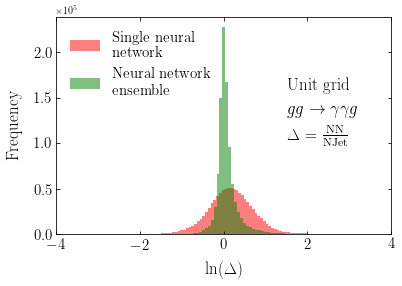

In [52]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.hist(log_single_delta, bins=200, color='red', alpha=0.5, label='Single neural\nnetwork')
plt.hist(log_fks_delta, bins=200, color='green', alpha=0.5, label='Neural network\nensemble')
plt.legend(prop={"size":15}, frameon = False, loc = 'upper left')
plt.xlim((-4,4))

plt.tick_params(axis='x', labelsize=15, direction = 'in', top = True)
plt.tick_params(axis='y', labelsize=15, direction = 'in', right = True)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.ylabel('Frequency', fontsize=17, labelpad=10)
plt.xlabel(r'ln($\Delta$)', fontsize=17, labelpad=10)

if grid_type == 'vegas':
    annotation_string = "VEGAS grid \n"
elif grid_type == 'unit':
    annotation_string = "Unit grid \n"
if legs == 5:
    annotation_string += r"$gg\to \gamma\gamma g$"
elif legs == 6:
    annotation_string += r"$gg\to \gamma\gamma gg$"
annotation_string += "\n"
annotation_string += r"$\Delta = \frac{\mathrm{NN}}{\mathrm{NJet}}$"
    
plt.text(1.5, 1e5, annotation_string, size=17,
         va="baseline", ha="left", multialignment="left", linespacing = 1.6)

plt.savefig(save_dir + save_fig + '.png', dpi=150, bbox_inches='tight')
plt.show()